# Okay... so... 
We have agents...

Suspicious ones
Not suspicious ones


Transactions should have:


We also want to export the network of transactions

So... the data we want are... 

sender - receiver - amount - timestamp

parameters:

num of agents,
avg txn hr -> so at any given point, the likelihood of making a transaction

avg txn value
distribution of p per agent type 
starting balance




In [417]:
# export some... network graphs i guess....
# also want to make some classifieirs

In [418]:
# Model design
import agentpy as ap
import numpy as np

# Visualization
import seaborn as sns
import pandas as pd

import scipy.stats
import datetime
import matplotlib.pyplot as plt

from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

# utility functions

### setup_p_txns

In [448]:
DEBUG = False

def setup_p_txns(total_steps):
    # Mean at 0
    max_std_devs = 5 # 

    if DEBUG:
        # Note: scipy norm has stddev = 1, mean of 0
        # Below shows why we pick max_std_devs = 5
        p_txn = scipy.integrate.quad(
                scipy.stats.norm.pdf, -5, 5)[0] # quad() Returns: value, error
        print('In total we will capture this amount of the gaussian: ', p_txn)
    
    txn_probabilities = np.ones(total_steps) * -1

    std_dev_per_step = 2 * max_std_devs / total_steps

    for step in range(total_steps):
        p_txn = \
            scipy.integrate.quad(
                scipy.stats.norm.pdf, 
                -max_std_devs + step * std_dev_per_step, 
                -max_std_devs + (step+1) * std_dev_per_step
            ) # returns: (integration) value, error
        txn_probabilities[step] = p_txn[0]
        if DEBUG:
            print(step, p_txn[0])
    # The peak should be at 0, not halfway through)
    zeroing_shift = int(np.round(txn_probabilities.shape[0] / 2))
    shifted = np.concatenate(
            (txn_probabilities[-zeroing_shift:], 
            txn_probabilities[:-zeroing_shift]))

    if False:
        # In txn time plot,
        # Should see peaks exactly at the means for each type of agent
        txn_probabilities[0] = 1 # set p_txn to 1 to always transact
        txn_probabilities[1:-1] = 0.01 # or Zero

    return shifted 

In [449]:
with np.printoptions(precision=3, suppress=True):
    test = setup_p_txns(96)
    display(test)

array([0.041, 0.041, 0.04 , 0.039, 0.037, 0.035, 0.033, 0.031, 0.028,
       0.025, 0.023, 0.02 , 0.018, 0.015, 0.013, 0.011, 0.009, 0.008,
       0.006, 0.005, 0.004, 0.003, 0.003, 0.002, 0.002, 0.001, 0.001,
       0.001, 0.001, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.001, 0.001, 0.001, 0.001, 0.002,
       0.002, 0.003, 0.003, 0.004, 0.005, 0.006, 0.008, 0.009, 0.011,
       0.013, 0.015, 0.018, 0.02 , 0.023, 0.025, 0.028, 0.031, 0.033,
       0.035, 0.037, 0.039, 0.04 , 0.041, 0.041])

# agent

### TODO: rename send_sxn_times

Here send is a noun, but looks like verb

In [466]:
class BankAgent(ap.Agent):
    def setup(self):
        self.txn_amt_rng = None 
        self.txn_probabilities = None 
        self.type = None 
        self.acct_balance = None 
        self.mean_txns = 4
        self.send_txn_times = []

        self.txns = None
        self.txns_list = []
        self.txn_amts = None

    def setup_txn_amts(self, mean=100, stddev=10, total_steps=0):
        self.txn_amts = self.txn_amt_rng.normal(
            loc=mean, scale=stddev, 
            size=total_steps)

    # NOTE: Timesteps start at 1
    # TODO: fix bug. where first timestep should be at midnight.
    # TODO: fix so stored txn time can be timestep, not timestep-1
    # TOOD: issue currently is graph has both midnight 10/31 and midngith 11/1
    # TODO: due to resample rounding up or down or something idk
    def transact(self, timestep):
        # using as index, subtract (timestep starts at 1)
        p_txn = self.txn_probabilities[timestep-1] * self.mean_txns

        if np.random.random() < p_txn and self.acct_balance > 0:
            # using as value, do nothing
            self.send_txn_times.append(timestep) #TODO: should be timestep
            # randomly choose partner
            my_partner = self.model.agents.random() # we get a list back
            my_partner = my_partner.to_list()[0] 
            # randomly choose amount
            amount = self.txn_amts[timestep-1]

            # calculations
            my_partner.acct_balance += amount
            self.acct_balance -= amount

            if DEBUG:
                print(
                    f' Transaction @ step: {timestep} with ptxn: {p_txn:.2f}, '
                    f'${amount:.2f} from: {self.id}->{my_partner.id}, '
                    f'({self.type} to {my_partner.type}), new balance: {self.acct_balance:.1f}'
                )

            # Note that txn_type is redundant info (e.g. can be derived from +/- of amount)
            self.txns_list.append([ timestep, 'send', self.id, self.type,
                my_partner.id, my_partner.type, -amount, self.acct_balance])

            my_partner.txns_list.append([
                timestep, 'receive', self.id, self.type, my_partner.id, my_partner.type,
                amount, my_partner.acct_balance])

    def cleanup(self):
        self.txns = pd.DataFrame(self.txns_list,
            columns=['timestep', 'txn_type', 'sender_id', 'sender_type', 
            'receiver_id', 'receiver_type', 'amount', 'acct_balance',] )

# parameters

In [467]:
NUM_AGENTS_PER_TYPE = {
    'normal': 100,
    'suspicious': 10, 
}

MEAN_TXN_HRS = {'normal':14, 
                'suspicious':22}

MINS_PER_STEP = 15

MEAN_TXN_AMOUNTS = {'normal':250, 
                'suspicious':50}


parameters = {
    'num_agents_per_type': NUM_AGENTS_PER_TYPE,
    'mean_txn_hrs': MEAN_TXN_HRS,
    'mean_txn_amounts ': MEAN_TXN_AMOUNTS,
    'mean_txns': 4, # avg num txns each agent makes
    'starting_balance': 100,
    'seed': 42,
    'mins_per_step' : MINS_PER_STEP, # 1 hr
    'steps': int(24 * (60/MINS_PER_STEP)), # 24 hours * steps per hr
}

# For plotting
def timestep_to_time(timestep):
    date_and_time = datetime.datetime(2022, 10, 31, 0, 0, 0)
    time_elapsed = timestep * (parameters['mins_per_step'])
    time_change = datetime.timedelta(minutes=time_elapsed)
    new_time = date_and_time + time_change
    return new_time

# model

In [482]:
class BankModel(ap.Model):
    def setup(self):
        self.p_txns = setup_p_txns(self.p.steps) 
        num_agents = sum(self.p.num_agents_per_type.values())
        
        # Setup up rng to generate seeds for rngs for agents
        rng = np.random.default_rng(self.p.seed)
        agent_rng_seeds = rng.random(num_agents).round(3) * 1000
        agent_rng_seeds = np.array(agent_rng_seeds, dtype=int)

        self.agents = ap.AgentList(self) 
        # -- shift the tables 
        for type in ['normal', 'suspicious']:
            hrs_mean = self.p.mean_txn_hrs[type]
            # shift in steps
            # originally peak at 0, now peak at (mean time)
            shift_amt = hrs_mean * int(60 / self.p.mins_per_step)
            shifted = np.concatenate(
                (self.p_txns[-shift_amt:], self.p_txns[:-shift_amt]))
            agents = ap.AgentList(
                self, self.p.num_agents_per_type[type], BankAgent)

            agents.txn_probabilities = shifted
            agents.total_steps = self.p.steps 
            agents.acct_balance = 100
            agents.type = type

            self.agents += agents

        if DEBUG:
            print('here are all the agetns: ')
            print(self.agents)
            print([(agent.id,agent.type) for agent in self.agents])

        # calcuations for txn values
        txn_amt_rngs = ap.AttrIter(
            [np.random.default_rng(seed) for seed in agent_rng_seeds])
        self.agents.txn_amt_rng = txn_amt_rngs

        for agent in self.agents:
            agent.setup_txn_amts(
                mean=20, stddev=5, total_steps=self.p.steps)

    def step(self):
        self.agents.transact(self.t)

    def update(self):
        pass
        '''
        if DEBUG:
            total_txns = 0
            for agent in self.agents:
                num_txns = agent.txns[agent.txns.txn_type == 'send'].shape[0]
                total_txns += num_txns
            print('num txns (across all agents)', total_txns)
        '''

    def end(self):
        self.agents.record('send_txn_times')
        
        for agent in self.agents:
            agent.cleanup()

In [483]:
np.random.default_rng(42).normal()

0.30471707975443135

# run

In [484]:
model = BankModel(parameters)
results = model.run()

Completed: 96 steps
Run time: 0:00:00.139871
Simulation finished


# Plot

In [485]:
# For plotting
def timestep_to_time(timestep):
    date_and_time = datetime.datetime(2022, 10, 31, 0, 0, 0)
    time_elapsed = timestep * (parameters['mins_per_step'])
    time_change = datetime.timedelta(minutes=time_elapsed)
    new_time = date_and_time + time_change
    return new_time

In [486]:
if DEBUG:
    for agent in model.agents:
        print(agent.txns)
display(model.agents[0].txns)

,timestep,txn_type,sender_id,sender_type,receiver_id,receiver_type,amount,acct_balance
0,42,receive,98,normal,1,normal,21.177328,121.177328
1,56,receive,48,normal,1,normal,22.194552,143.371879
2,57,receive,65,normal,1,normal,22.868953,166.240833
3,60,receive,100,normal,1,normal,23.636450,189.877283
4,62,send,1,normal,86,normal,-16.819260,173.058023
5,64,send,1,normal,52,normal,-16.109051,156.948972
6,67,receive,52,normal,1,normal,24.493819,181.442791
7,75,send,1,normal,73,normal,-24.358861,157.083930


In [473]:
# transaction amount, sender, receiver, timestamp

In [474]:
results.info

{'model_type': 'BankModel',
 'time_stamp': '2022-12-09 18:41:48',
 'agentpy_version': '0.1.5',
 'python_version': '3.10.',
 'experiment': False,
 'completed': True,
 'created_objects': 110,
 'completed_steps': 96,
 'run_time': '0:00:00.147302'}

In [475]:
# okay so now i want to... uh... okay histogram plot of when txns are occuring
# then i want to ... make a network of who transacted with who

In [476]:
if DEBUG:
    model.agents.acct_balance

In [477]:
#sns.histplot(model.agents.acct_balance)
model.agents[0].txns#.where('txn_type
model.agents.txns.shape
#model.agents.txns[1]

[(9, 8), (6, 8), (5, 8), (6, 8), (8, 8), (9, 8), (8, 8), (15, 8), (12, 8), (10, 8), (8, 8), (9, 8), (11, 8), (7, 8), (7, 8), (7, 8), (6, 8), (9, 8), (7, 8), (6, 8), (11, 8), (10, 8), (6, 8), (4, 8), (10, 8), (7, 8), (3, 8), (13, 8), (10, 8), (10, 8), (9, 8), (10, 8), (7, 8), (7, 8), (9, 8), (6, 8), (4, 8), (10, 8), (5, 8), (5, 8), (6, 8), (5, 8), (7, 8), (11, 8), (4, 8), (5, 8), (7, 8), (5, 8), (10, 8), (8, 8), (5, 8), (10, 8), (9, 8), (7, 8), (14, 8), (2, 8), (7, 8), (7, 8), (10, 8), (7, 8), (8, 8), (6, 8), (9, 8), (4, 8), (6, 8), (8, 8), (3, 8), (7, 8), (9, 8), (11, 8), (11, 8), (9, 8), (7, 8), (4, 8), (10, 8), (5, 8), (8, 8), (9, 8), (6, 8), (5, 8), (7, 8), (10, 8), (5, 8), (9, 8), (11, 8), (7, 8), (4, 8), (7, 8), (3, 8), (8, 8), (5, 8), (6, 8), (7, 8), (10, 8), (4, 8), (6, 8), (10, 8), (10, 8), (7, 8), (7, 8), (8, 8), (4, 8), (8, 8), (10, 8), (4, 8), (4, 8), (7, 8), (6, 8), (7, 8), (5, 8)]

In [478]:
all_txns = []
for agent in model.agents:
    #print(agent.id, 'with txns at timesteps: ',  agent.send_txn_times)
    #print('aka times: ') 

    for timestamp in agent.send_txn_times:
        #print( timestep_to_time(timestamp).strftime('%H:%M'))
        all_txns.append(timestep_to_time(timestamp))
    #print('the partners were: ', agent.txns[agent.txns.txn_type =='send'].receiver_id)
all_txns = pd.DataFrame( all_txns, columns=['send_txn_times' ])
all_txns.sort_values(by='send_txn_times')

,send_txn_times
373,2022-10-31 00:30:00
396,2022-10-31 00:45:00
380,2022-10-31 00:45:00
374,2022-10-31 01:00:00
397,2022-10-31 01:15:00
...,...
379,2022-10-31 23:15:00
399,2022-10-31 23:15:00
408,2022-10-31 23:15:00
402,2022-10-31 23:30:00


In [479]:
with np.printoptions(precision=3, suppress=True):
    display(model.agents[0].txn_probabilities)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.001, 0.001, 0.001, 0.001, 0.002, 0.002, 0.003, 0.003, 0.004,
       0.005, 0.006, 0.008, 0.009, 0.011, 0.013, 0.015, 0.018, 0.02 ,
       0.023, 0.025, 0.028, 0.031, 0.033, 0.035, 0.037, 0.039, 0.04 ,
       0.041, 0.041, 0.041, 0.041, 0.04 , 0.039, 0.037, 0.035, 0.033,
       0.031, 0.028, 0.025, 0.023, 0.02 , 0.018, 0.015, 0.013, 0.011,
       0.009, 0.008, 0.006, 0.005, 0.004, 0.003, 0.003, 0.002, 0.002,
       0.001, 0.001, 0.001, 0.001, 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   ])

In [480]:
all_txns.index = all_txns.send_txn_times
resampled = all_txns.send_txn_times.resample('15Min')#.count().plot()
#resampled = all_txns.send_txn_times.resample('1H')#.count().plot()
resampled.count()
df = pd.DataFrame(resampled.count())
df.columns=['num_txns']
df['labels'] = pd.to_datetime(df.index).strftime('%H:%M')

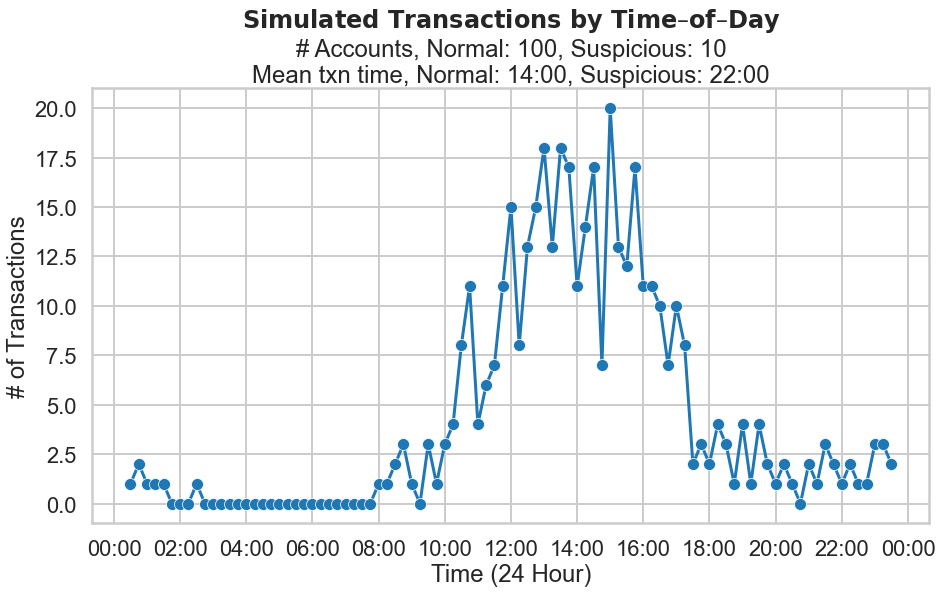

In [481]:
fig, ax = plt.subplots(figsize=(15,8))
sns.lineplot(x='send_txn_times', y='num_txns', data=df, ax=ax,
    markers=True,  marker='o')

# -- 
# format
sns.set_style('whitegrid')
sns.set_context('poster')

ax.set(xlabel='Time (24 Hour)', ylabel='# of Transactions',
# add title 
title=r"$\bf{Simulated\ Transactions\ by\ Time–of–Day}$" 
    f"\n# Accounts, Normal: {parameters['num_agents_per_type']['normal']}, "
    f"Suspicious: {parameters['num_agents_per_type']['suspicious']}\n"
    f"Mean txn time, Normal: {parameters['mean_txn_hrs']['normal']}:00,"
    f" Suspicious: {parameters['mean_txn_hrs']['suspicious']}:00"
    )

# 
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))